# Atelier 4 : Auto-encoder, Variational Auto-encoder and GANs

##Partie 1: AE and VAE

In [1]:
# Import lib
import torch, torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

In [2]:
# Define parameters
numb_batch = 64
num_epochs = 15
learning_rate = 0.001
latent_dim = 2

In [3]:
# Load DataSet : MNIST Dataset

T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

100%|██████████| 9912422/9912422 [00:00<00:00, 101697359.81it/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53316766.65it/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 73394511.21it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5097813.42it/s]


Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [4]:
# Define Auto-Encoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)  # Latent space representation
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Output is normalized between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
# Initialization for AE

ae = Autoencoder()
criterion_ae = nn.MSELoss()
optimizer_ae = optim.Adam(ae.parameters(), lr=learning_rate)
autoencoder_losses = []

In [6]:
# Training loop

for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_dl:
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)
        optimizer_ae.zero_grad()
        outputs = ae(inputs)
        loss = criterion_ae(outputs, inputs)
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dl.dataset)
    autoencoder_losses.append(epoch_loss)
    print(f"Epoch Numero : [{epoch+1}/{num_epochs}], Loss Value : {epoch_loss:.4f}")

Epoch Numero : [1/15], Loss Value : 0.0618
Epoch Numero : [2/15], Loss Value : 0.0433
Epoch Numero : [3/15], Loss Value : 0.0396
Epoch Numero : [4/15], Loss Value : 0.0374
Epoch Numero : [5/15], Loss Value : 0.0361
Epoch Numero : [6/15], Loss Value : 0.0352
Epoch Numero : [7/15], Loss Value : 0.0345
Epoch Numero : [8/15], Loss Value : 0.0339
Epoch Numero : [9/15], Loss Value : 0.0335
Epoch Numero : [10/15], Loss Value : 0.0332
Epoch Numero : [11/15], Loss Value : 0.0329
Epoch Numero : [12/15], Loss Value : 0.0326
Epoch Numero : [13/15], Loss Value : 0.0324
Epoch Numero : [14/15], Loss Value : 0.0322
Epoch Numero : [15/15], Loss Value : 0.0320


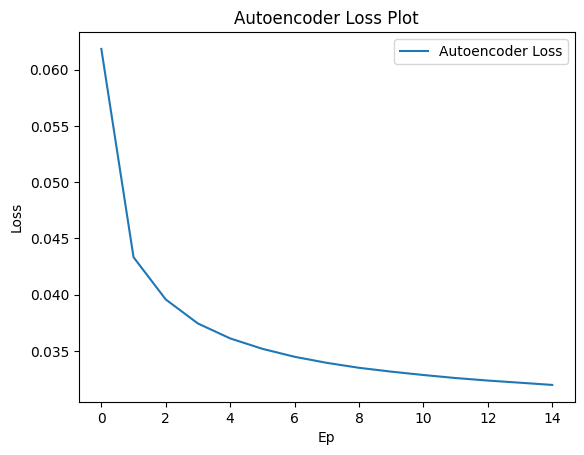

In [7]:
# Plot losses of Autoencoder

plt.plot(autoencoder_losses, label="Autoencoder Loss")
plt.xlabel('Ep')
plt.ylabel('Loss')
plt.legend()
plt.title("Autoencoder Loss Plot")
plt.show()

In [8]:
# Function for plot latent space (using PCA)
def plot_latent_space(encoder, data_loader, title):
    latent_vectors = []
    labels = []

    for inputs, targets in data_loader:
        inputs = inputs.view(inputs.size(0), -1)
        # Handle the case where the encoder returns only one tensor
        if isinstance(encoder(inputs), tuple):
            latent_mean, _ = encoder(inputs)
        else:
            latent_mean = encoder(inputs)
        latent_vectors.append(latent_mean.detach().numpy())
        labels.append(targets.numpy())

    latent_vectors = np.concatenate(latent_vectors)
    labels = np.concatenate(labels)

    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_vectors)

    plt.figure(figsize=(10, 8))
    plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=labels, cmap='tab10')
    plt.colorbar(label='Digit')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

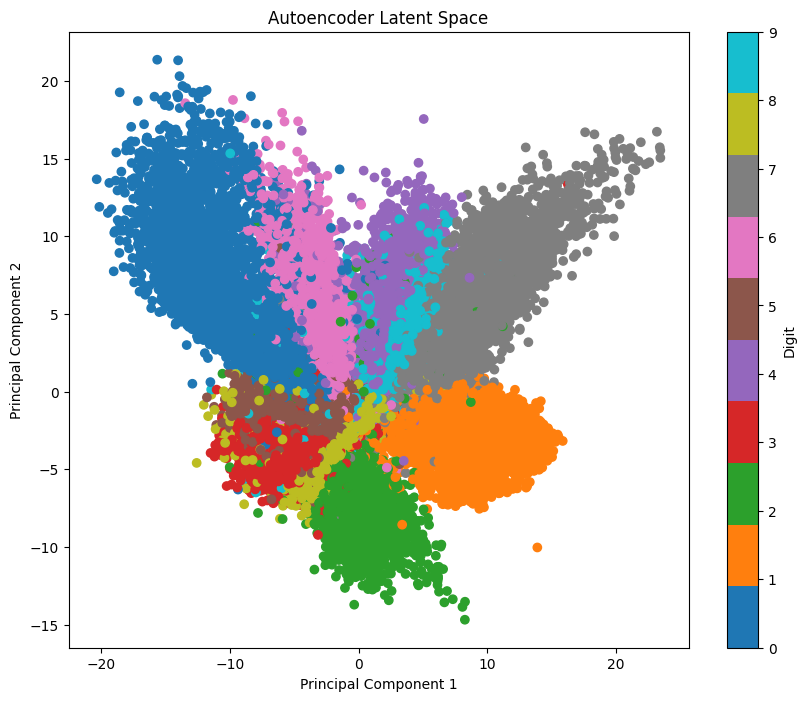

In [9]:
# Plot latent space for Autoencoder
plot_latent_space(ae.encoder, train_dl, "Autoencoder Latent Space")

In [10]:
# Class of the Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

In [11]:
# Initialization
vae = VAE(latent_dim)
criterion_vae = nn.BCELoss(reduction='sum')  # Binary Cross Entropy
optimizer_vae = optim.Adam(vae.parameters(), lr=learning_rate)
vae_losses = []
kl_divergences = []

In [12]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    running_kld = 0.0
    for data in train_dl:
        inputs, _ = data
        optimizer_vae.zero_grad()
        recon_batch, mu, logvar = vae(inputs)
        BCE = criterion_vae(recon_batch, inputs.view(-1, 28 * 28))
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = BCE + KLD
        loss.backward()
        optimizer_vae.step()
        running_loss += loss.item()
        running_kld += KLD.item()
    epoch_loss = running_loss / len(train_dl.dataset)
    epoch_kld = running_kld / len(train_dl.dataset)
    vae_losses.append(epoch_loss)
    kl_divergences.append(epoch_kld)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, KL Divergence: {epoch_kld:.4f}")

Epoch [1/15], Loss: 188.2324, KL Divergence: 2.7293
Epoch [2/15], Loss: 158.4161, KL Divergence: 5.3612
Epoch [3/15], Loss: 151.6164, KL Divergence: 5.8051
Epoch [4/15], Loss: 147.9665, KL Divergence: 6.0702
Epoch [5/15], Loss: 145.7680, KL Divergence: 6.2315
Epoch [6/15], Loss: 144.2508, KL Divergence: 6.3616
Epoch [7/15], Loss: 143.2606, KL Divergence: 6.4464
Epoch [8/15], Loss: 142.3977, KL Divergence: 6.5060
Epoch [9/15], Loss: 141.9346, KL Divergence: 6.5657
Epoch [10/15], Loss: 141.2944, KL Divergence: 6.6258
Epoch [11/15], Loss: 140.6690, KL Divergence: 6.6909
Epoch [12/15], Loss: 140.6149, KL Divergence: 6.7484
Epoch [13/15], Loss: 140.0144, KL Divergence: 6.7533
Epoch [14/15], Loss: 140.0211, KL Divergence: 6.7743
Epoch [15/15], Loss: 139.9514, KL Divergence: 6.7920


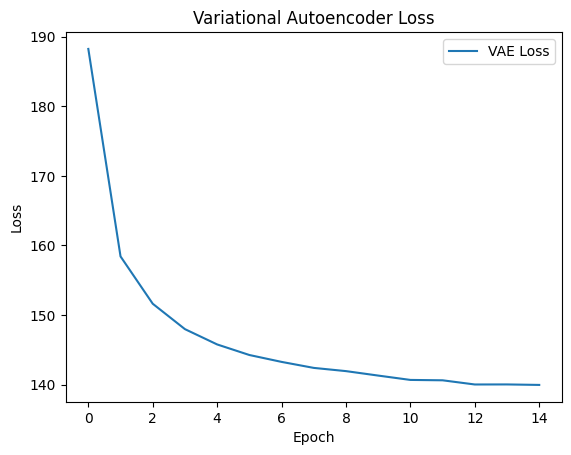

In [14]:
# losses for VAE
plt.plot(vae_losses, label="VAE Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Variational Autoencoder Loss")
plt.show()

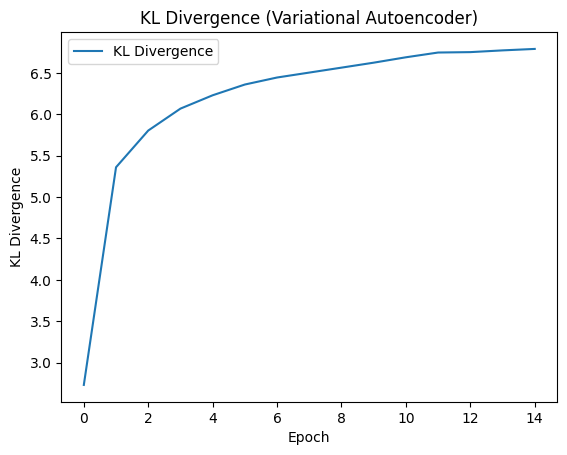

In [17]:
# KL divergence for VAE
plt.plot(kl_divergences, label="KL Divergence")
plt.xlabel('Epoch')
plt.ylabel('KL Divergence')
plt.legend()
plt.title("KL Divergence (Variational Autoencoder)")
plt.show()

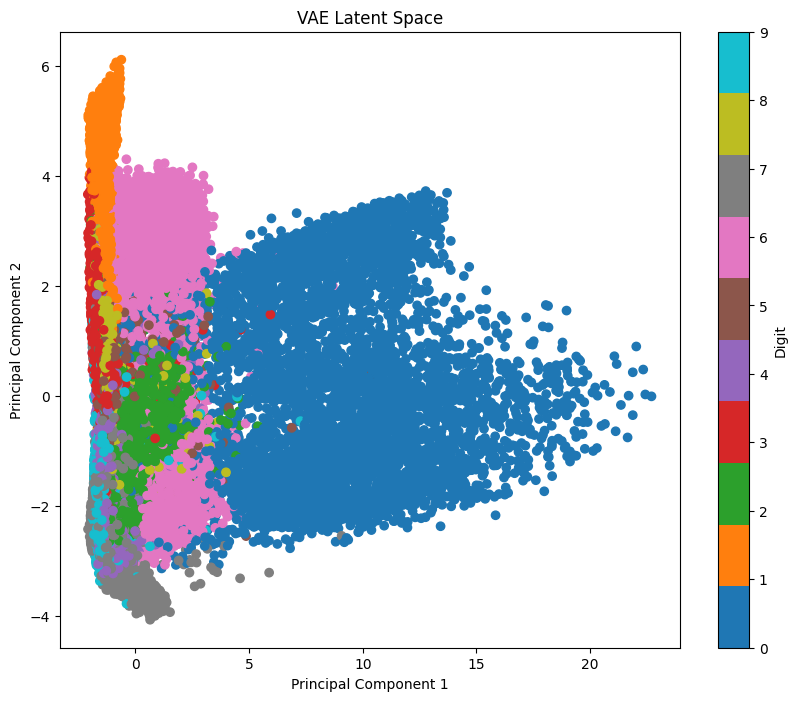

In [18]:
# Latent space for VAE
plot_latent_space(vae.encoder, train_dl, "VAE Latent Space")

### **Commentaire**

**AE Plot**

Le plot montre une diminution de la loss à chaque epoch pendant l'entraînement de l'Autoencoder (AE), indiquant une meilleure reconstruction des images au fil du temps.

**VAE Plot**

Le graphique montre une diminution de la VAE Loss, mais une augmentation de la KL Divergence à chaque epoch, suggérant une amélioration de la reconstruction et une divergence accrue entre les distributions latentes et prior.

# Partie 2 : GANs

In [19]:
pip install opendatasets

In [20]:
# Import lib

import pandas as pd
import os
import opendatasets as od
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
%matplotlib inline
import torch.nn as nn
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
from IPython.display import Image

In [22]:
# Importer dataset automatiquement
# pip install opendatasets

dataset = 'https://www.kaggle.com/datasets/bryanb/abstract-art-gallery'
od.download(dataset)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: hindelouahabi
Your Kaggle Key: ··········


100%|██████████| 693M/693M [00:23<00:00, 31.1MB/s]


In [23]:
# Define variables
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
DATA_DIR = './abstract-art-gallery/Abstract_gallery/'

In [24]:
# Prepare dataser
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
                                                      T.Resize(image_size),
                                                      T.CenterCrop(image_size),
                                                      T.ToTensor(),
                                                      T.Normalize(*stats)]))
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


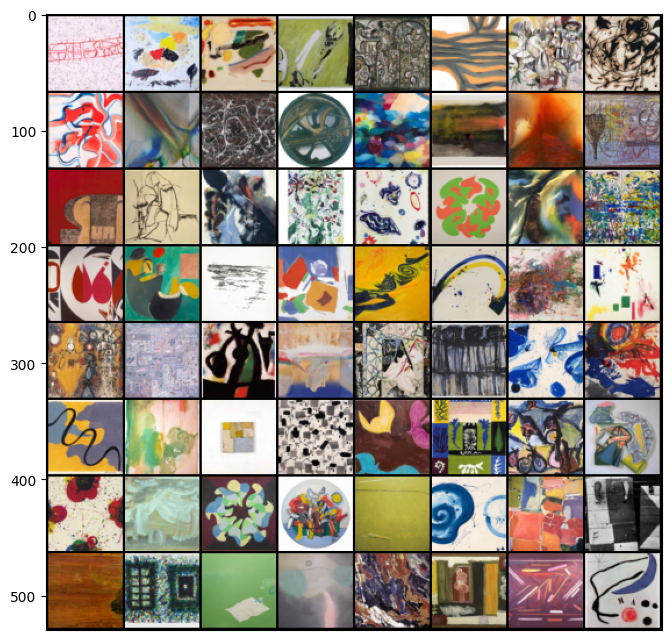

In [25]:
# Functions to visualizing images
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images,nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_xticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))

def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

show_batch(train_dl)

In [26]:
# Define data loaders across different devices

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
device

device(type='cuda')

In [27]:
# Define Discriminator Architechture

discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device)

latent_size = 128

In [28]:
# Define Generator Architechture

generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

In [29]:
# Moves the generator model (generator) to the specified device
generator = to_device(generator, device)

In [30]:
# Training the discriminator model

def train_discriminator(real_images, opt_d):

    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [31]:
# Training the generator model

def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    loss.backward()
    opt_g.step()

    return loss.item()

In [32]:
# Create directory to save new Dataset

sample_dir = 'new_dataset'
os.makedirs(sample_dir, exist_ok=True)

In [33]:
# Function to save generated images

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [34]:
# Generates a tensor of fixed random latent
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [35]:
#  Training a Generative Adversarial Network (GAN)

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Define optimizers (ADAM)
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        print("Epoch Num : [{}/{}], loss_gene: {:.4f}, loss_disc: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [36]:
# Define hyperparameters
lr = 0.0002
epochs = 20

In [37]:
# Start training and generate new dataset
history = fit(epochs, lr)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [1/20], loss_gene: 10.9996, loss_disc: 0.4040, real_score: 0.6935, fake_score: 0.0007
Saving generated-images-0001.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [2/20], loss_gene: 3.4862, loss_disc: 0.4327, real_score: 0.7320, fake_score: 0.0863
Saving generated-images-0002.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [3/20], loss_gene: 3.9270, loss_disc: 0.3938, real_score: 0.8263, fake_score: 0.1681
Saving generated-images-0003.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [4/20], loss_gene: 4.8194, loss_disc: 0.0811, real_score: 0.9588, fake_score: 0.0372
Saving generated-images-0004.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [5/20], loss_gene: 3.7909, loss_disc: 5.1323, real_score: 0.0217, fake_score: 0.0030
Saving generated-images-0005.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [6/20], loss_gene: 3.3219, loss_disc: 0.3252, real_score: 0.8158, fake_score: 0.1081
Saving generated-images-0006.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [7/20], loss_gene: 6.2745, loss_disc: 0.2946, real_score: 0.9590, fake_score: 0.2202
Saving generated-images-0007.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [8/20], loss_gene: 8.2673, loss_disc: 0.6246, real_score: 0.9682, fake_score: 0.3998
Saving generated-images-0008.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [9/20], loss_gene: 6.6301, loss_disc: 0.2548, real_score: 0.9391, fake_score: 0.1545
Saving generated-images-0009.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [10/20], loss_gene: 4.1780, loss_disc: 0.2564, real_score: 0.9104, fake_score: 0.1418
Saving generated-images-0010.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [11/20], loss_gene: 3.9899, loss_disc: 0.1737, real_score: 0.9166, fake_score: 0.0776
Saving generated-images-0011.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [12/20], loss_gene: 5.7342, loss_disc: 0.1063, real_score: 0.9340, fake_score: 0.0332
Saving generated-images-0012.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [13/20], loss_gene: 3.4936, loss_disc: 0.2882, real_score: 0.8522, fake_score: 0.1032
Saving generated-images-0013.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [14/20], loss_gene: 1.8704, loss_disc: 0.8987, real_score: 0.5764, fake_score: 0.1668
Saving generated-images-0014.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [15/20], loss_gene: 2.7018, loss_disc: 0.5797, real_score: 0.8765, fake_score: 0.3477
Saving generated-images-0015.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [16/20], loss_gene: 2.9325, loss_disc: 0.7975, real_score: 0.8866, fake_score: 0.4581
Saving generated-images-0016.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [17/20], loss_gene: 2.3203, loss_disc: 0.5250, real_score: 0.7520, fake_score: 0.1783
Saving generated-images-0017.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [18/20], loss_gene: 3.3214, loss_disc: 0.4724, real_score: 0.7210, fake_score: 0.0752
Saving generated-images-0018.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [19/20], loss_gene: 4.0194, loss_disc: 0.2782, real_score: 0.8819, fake_score: 0.1320
Saving generated-images-0019.png


  0%|          | 0/22 [00:00<?, ?it/s]

Epoch Num : [20/20], loss_gene: 2.8987, loss_disc: 0.8091, real_score: 0.5790, fake_score: 0.0728
Saving generated-images-0020.png


In [38]:
# Get Losses from history of training
losses_g, losses_d, real_scores, fake_scores = history

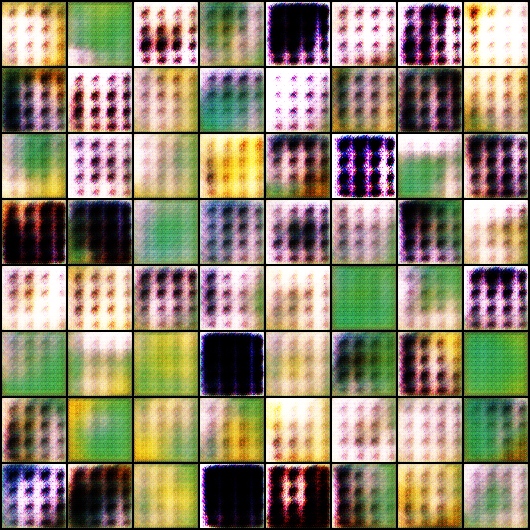

In [39]:
# Show Example of dataset generated
Image('./new_dataset/generated-images-0020.png')

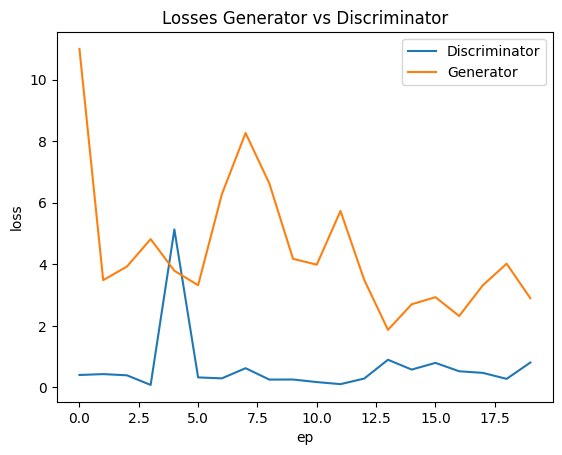

In [40]:
# Plot some losses
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('ep')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses Generator vs Discriminator');

### Conclusion

**Perte du Discriminateur (Loss_disc):**

La perte du discriminator diminue progressivement au fur et à mesure des époques. Cela indique que le discriminateur apprend à mieux distinguer les vraies images des fausses images générées par le generator.

**Perte du Générateur (Loss_gene):**

La perte du generator varie au fil des époques, mais elle semble globalement décroître. Cela montre que le générateur apprend à produire des images plus convaincantes au fur et à mesure de l'entraînement, bien que des fluctuations puissent survenir en raison de l'interaction dynamique entre le generator et le discriminator.